# SVM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from models.svm import SVM
from utils.datasets import toy_classification_dataset, radial_classification_dataset
from utils.visualization import plot_decision_boundary

In [2]:
%matplotlib inline

# Turn interactive plotting off
plt.ioff()

In [3]:
(x_train, y_train), (x_test, y_test) = toy_classification_dataset(features=2, classes=2)

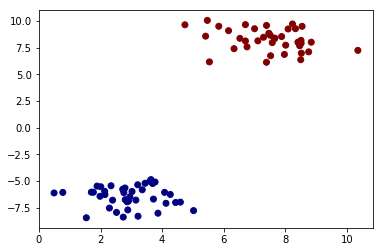

In [4]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [5]:
model = SVM()

In [6]:
y_train.shape

(80,)

In [7]:
loss = model.fit(x_train, y_train, iterations=1000)

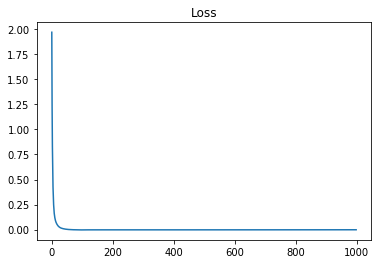

In [8]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

In [9]:
model.predict(x_test)

array([1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 0., 0.])

In [10]:
y_hat = model.predict(x_test)

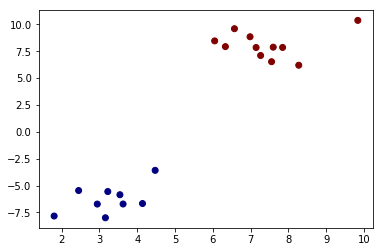

In [11]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_hat, cmap='jet')
plt.show()

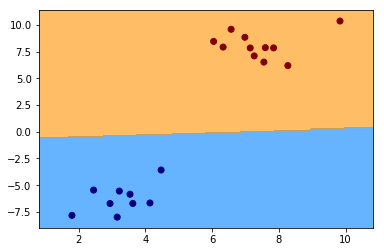

In [12]:
ax = plot_decision_boundary(model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet', label='True classes')
plt.show()

# Non-linearly separable dataset

In [13]:
(x_train, y_train), (x_test, y_test) = radial_classification_dataset()

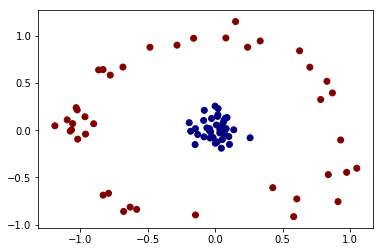

In [14]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In [15]:
loss = model.fit(x_train, y_train, iterations=10000)

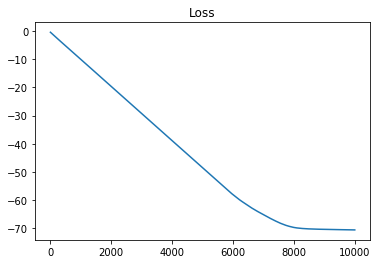

In [16]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

In [17]:
y_hat = model.predict(x_test)

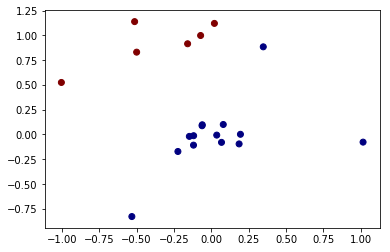

In [18]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_hat, cmap='jet')
plt.show()

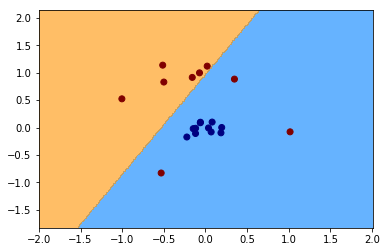

In [19]:
ax = plot_decision_boundary(model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet', label='True classes')
plt.show()

# Kernel trick

In [20]:
quadratic_model = SVM(kernel='quadratic')

In [21]:
loss = quadratic_model.fit(x_train, y_train, iterations=10000)

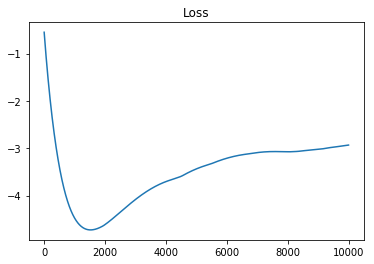

In [22]:
plt.plot(loss[1:])
plt.title('Loss')
plt.show();

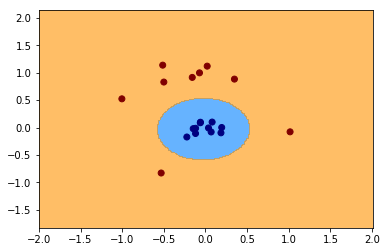

In [24]:
ax = plot_decision_boundary(quadratic_model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet', label='True classes')
plt.show()